In [1]:
%matplotlib inline
# %matplotlib notebook # Does not work 
import pickle 
import numpy as np
from matplotlib import pyplot as plt
import json
from hpbandster.core.result import logged_results_to_HBS_result
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime
import os

import pprint

In [2]:
def open_hpo_results_files(file):
    with open(file, 'rt') as f_in:
        raw = []
        for line in f_in:
            raw.append(json.loads(line))
        return raw

In [3]:
def load_hpo_results(results_dir):
    results_file = results_dir + 'results.json'
    config_file = results_dir + 'configs.json'
    return {
        'results_lines': open_hpo_results_files(results_file),
        'config_lines': open_hpo_results_files(config_file)        
        }

In [4]:
def load_results(file):
    with open(file, 'rt') as f_in:
        results = []
        for line in f_in:
#             line = line.strip('\n')
            results.append(json.loads(line))
    
#         if not results:
#             return
        data_budget = 0
        if 's1' in results[0][3]['info'].keys():
            fold = 's1'
        else: 
            fold = 's'
        out_dict = {'loss_data': [x[3]['loss'] for x in results if x[1] >= data_budget], # Only get runs evaluated on 100% data budget 
#         return {'loss_data': [x[3]['loss'] for x in results], # Get only runs on 100% of data
#                 'dataset': 'tvqa',
#                 'hpo_method': file.split('/')[-2].split('_')[2],
                'times': [x[2] for x in results if x[1] >= data_budget],
                'model_file': [x[3]['info'][fold]['info']['model_file'] for x in results if x[1] >= data_budget],
                'file': file
               }
#         print(results[0][3]['info'].keys())
        if 'mean_metric_test' in results[0][3]['info'].keys():
            if 'tvqa' in file.lower():
                out_dict['test_results'] = [x[3]['info'][fold]['info']['test_results'] for x in results if x[1] >= data_budget]
            else:
                out_dict['test_results'] = [x[3]['info']['mean_metric_test'] for x in results if x[1] >= data_budget]
#             print(out_dict['test_results'][0:10])
                
    return out_dict

In [5]:
def get_hpo_results_dir(workdir, hpo_method):
    
    results_dirs = []
    for root, dirs, files in os.walk(workdir, topdown=False):
        for name in dirs:
#             if (hpo_method in name) and ('1574849754' in name):
            if (hpo_method in name):
                results_dirs.append(os.path.join(root, name))
    return results_dirs

In [6]:
def plot_results(dataset, hpo_method, *plots, dev_def=0, test_def=0, n=0, n_lim=0, time_flag=False, raw_flag=False, grid_f=False):

        
    f = plt.figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
    plt.clf()

#     plt.title(dataset.upper() + ' HPO validation set' )
    
    
    signals = []
    run_id = 0
        
    stats = []
    for plot_data in plots:
        run_id += 1
        plot_id = plot_data['file'].split('/')[-2]
        len_data = len(plot_data['loss_data'])
        
        if (n_lim < len_data) and (n_lim > 0):
            n_up = n_lim
        else:
            n_up = len_data
        
#         print('n_up', n_up)

#         y_results = [1 - min(plot_data['loss_data'][0:i+1]) for i,x in enumerate(plot_data['loss_data'])]
        y_results = [1 - min(plot_data['loss_data'][0:i+1]) for i,x in enumerate(plot_data['loss_data'])]
        
        max_file = plot_data['model_file'][plot_data['loss_data'][0:n_up].index(min(plot_data['loss_data'][0:n_up]))]
        init_file = plot_data['model_file'][0]
#         print('KOKOKO', init_file)
        max_metric = round(1 - min(plot_data['loss_data'][0:n_up]),4)
        
        inverse_loss = [1 - x for x in plot_data['loss_data']]
    
        if time_flag:
            initial = plot_data['times'][0]['submitted']
#             time_diff = plot_data['times'][-1]['finished'] - 
#             idx = list(np.linspace(0, time_diff, num=len(metric_max_avg)))
            idx = [x['finished'] - initial for x in plot_data['times']]
            print('HOHO first', idx[0])
            idx = [x/60 for x in idx]
            plt.xlabel('wallclock-time [min]', fontsize = 13)
                        
        else:
            idx = list(range(1,len(y_results)+1))
            plt.xlabel('# function evaluations', fontsize = 13)
#             plt.xlabel('# function evaluations on 100% budget', fontsize = 13)
                    
        if dataset == 'tvqa':   
            metric = 'ACC'
            
        else:
            metric = 'MAP'
        
        plt.ylabel('Max ' + metric + ' after # function evaluations', fontsize = 13)
            
#         print('n_up: ', n_up, len(idx[n:n_up]))
        
#         p = plt.plot(idx[n:n_up], y_results[n:n_up], label = hpo_method.upper() + '_'+ plot_id)
        p = plt.plot(idx[n:n_up], y_results[n:n_up], label = hpo_method.upper() + '_'+ str(run_id))

        
#         print(p[0].get_color())

#         duration = plot_data['times'][n_up-1]['finished'] - plot_data['times'][0]['submitted']
        duration = plot_data['times'][n_up-1]['finished'] - plot_data['times'][0]['submitted'] # after 100 func. evals
#         print('Duration! -see comment in code: ', round(duration/3600,2), # Careful: I concatenated results from different run dates!


#         print('Duration (' + str(n_up) + ' evals): ', round(duration/60,2), # Careful: I concatenated results from different run dates!
#               'mins', 'plot_id: ', plot_id,
#               'Max metric: ', max_metric,
#               'Max file: ', max_file,
#               'Length: ', n_up)    
        
        if 'test_results' in plot_data.keys():
            print('yes, test data!')
#             test_y = [max(plot_data['test_results'][0:i+1]) for i,x in enumerate(plot_data['test_results'])]
            test_y = plot_data['test_results']
            plt.axhline(y=test_def, color='r', linestyle='--', label = 'Test default hp')
            plt.plot(idx[n:n_up], test_y[n:n_up], linestyle='--', color=p[0].get_color(),  label = 'Test_' + plot_id)
            
            
            min_val = min(plot_data['loss_data'])
            idx_min = plot_data['loss_data'].index(min_val)             
            min_val_config = plot_data['model_file'][idx_min]
            print('Max val config!: ', min_val_config, '; Max val value: ', 1 - min_val)
            
            max_test = max(plot_data['test_results'])
            idx_max = plot_data['test_results'].index(max_test)             
            max_test_config = plot_data['model_file'][idx_max]
            print('Max test config!: ', max_test_config, '; Max test value: ', max_test)
            
        if raw_flag:
            plt.plot(idx[n:n_up], inverse_loss[n:n_up], label = 'Raw '+ hpo_method.upper(), color=p[0].get_color(), alpha=0.3)
        
        signals.append([y_results[n:n_up], idx[n:n_up]])
        
        n_evals_overcome = y_results.index([x for x in y_results if x > dev_def][0])
        
        stats_dict = {
            'run_id': run_id,
            'subject': dataset + '_' + hpo_method,
            'metric': metric,
            'initial_metric': round(y_results[0],4), 
            'init_HP': init_file.split('_')[-3:],
            'max_HP': max_file.split('_')[-3:],
            'max_metric': max_metric,
            'duration_100_eval_min': round(duration/60,2),
            'n_evals_overcome_defa': n_evals_overcome
            
        }
        stats.append(stats_dict)
        
#     plt.plot([x/hour for x in incumbent_bohb['times_finished']], incumbent_bohb['losses'])
    
    dev_line = plt.axhline(y=dev_def, color='r', linestyle='--', label = 'Default HP')
    
    plt.legend(loc = 'lower right')
    plt.grid(grid_f, which="both")
    plt.show()
    
#     pp.close()
    pdf_file = 'hpo_' + dataset + '_' + hpo_method + '_curves.pdf'
    f.savefig(pdf_file, bbox_inches='tight')
    
    
    return [signals, stats]

In [7]:
def get_best_config(*results_dirs):
    
    for results_dir in results_dirs:
        results = logged_results_to_HBS_result(results_dir)
        print( {'dir': results_dir,
                'config': results.get_id2config_mapping()[results.get_incumbent_id()]['config'],
                'mean_metric': results.get_runs_by_id(results.get_incumbent_id())[-1].info['mean_metric']
               }, '\n' )



###############################
####### New Graph #############

100


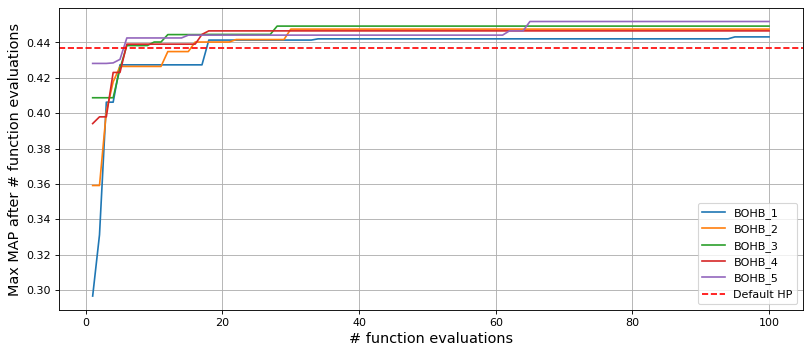

[{'run_id': 1, 'subject': 'bioasq_bohb', 'metric': 'MAP', 'initial_metric': 0.2966, 'init_HP': ['leaves25', 'lr0.04', 'n1700'], 'max_HP': ['leaves55', 'lr0.16', 'n150'], 'max_metric': 0.4431, 'duration_100_eval_min': 76.97, 'n_evals_overcome_defa': 17}, {'run_id': 2, 'subject': 'bioasq_bohb', 'metric': 'MAP', 'initial_metric': 0.3591, 'init_HP': ['leaves191', 'lr0.32', 'n2877'], 'max_HP': ['leaves8', 'lr0.55', 'n2093'], 'max_metric': 0.4475, 'duration_100_eval_min': 40.3, 'n_evals_overcome_defa': 15}, {'run_id': 3, 'subject': 'bioasq_bohb', 'metric': 'MAP', 'initial_metric': 0.4087, 'init_HP': ['leaves60', 'lr0.05', 'n1300'], 'max_HP': ['leaves90', 'lr0.13', 'n1750'], 'max_metric': 0.4492, 'duration_100_eval_min': 103.01, 'n_evals_overcome_defa': 5}, {'run_id': 4, 'subject': 'bioasq_bohb', 'metric': 'MAP', 'initial_metric': 0.3941, 'init_HP': ['leaves45', 'lr0.31', 'n1950'], 'max_HP': ['leaves55', 'lr0.16', 'n200'], 'max_metric': 0.4465, 'duration_100_eval_min': 57.26, 'n_evals_overcom

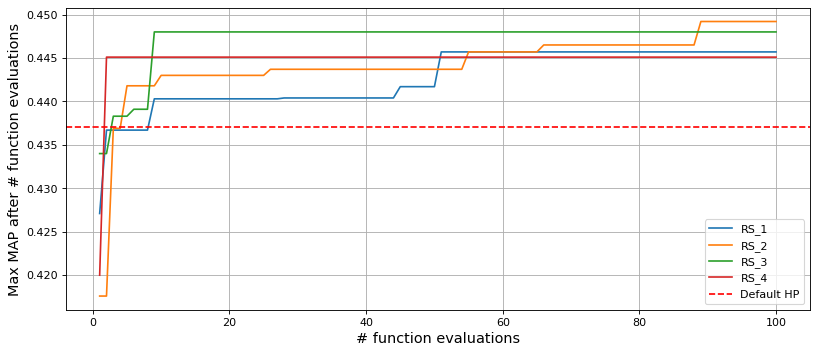

[{'run_id': 1, 'subject': 'bioasq_rs', 'metric': 'MAP', 'initial_metric': 0.4271, 'init_HP': ['leaves45', 'lr0.06', 'n150'], 'max_HP': ['leaves85', 'lr0.07', 'n1450'], 'max_metric': 0.4457, 'duration_100_eval_min': 109.7, 'n_evals_overcome_defa': 8}, {'run_id': 2, 'subject': 'bioasq_rs', 'metric': 'MAP', 'initial_metric': 0.4176, 'init_HP': ['leaves75', 'lr0.08', 'n100'], 'max_HP': ['leaves90', 'lr0.13', 'n1650'], 'max_metric': 0.4492, 'duration_100_eval_min': 111.69, 'n_evals_overcome_defa': 4}, {'run_id': 3, 'subject': 'bioasq_rs', 'metric': 'MAP', 'initial_metric': 0.434, 'init_HP': ['leaves5', 'lr0.46', 'n400'], 'max_HP': ['leaves5', 'lr0.16', 'n1150'], 'max_metric': 0.448, 'duration_100_eval_min': 115.14, 'n_evals_overcome_defa': 2}, {'run_id': 4, 'subject': 'bioasq_rs', 'metric': 'MAP', 'initial_metric': 0.42, 'init_HP': ['leaves40', 'lr0.29', 'n750'], 'max_HP': ['leaves55', 'lr0.06', 'n1750'], 'max_metric': 0.4451, 'duration_100_eval_min': 80.34, 'n_evals_overcome_defa': 1}]


#

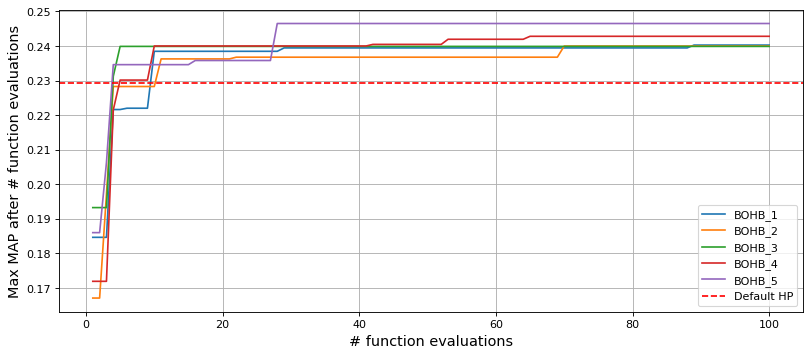

[{'run_id': 1, 'subject': 'robust_bohb', 'metric': 'MAP', 'initial_metric': 0.1847, 'init_HP': ['leaves41', 'lr0.18', 'n209'], 'max_HP': ['leaves20', 'lr0.13', 'n590'], 'max_metric': 0.2403, 'duration_100_eval_min': 408.95, 'n_evals_overcome_defa': 9}, {'run_id': 2, 'subject': 'robust_bohb', 'metric': 'MAP', 'initial_metric': 0.1671, 'init_HP': ['leaves50', 'lr0.43', 'n100'], 'max_HP': ['leaves20', 'lr0.12', 'n350'], 'max_metric': 0.24, 'duration_100_eval_min': 458.48, 'n_evals_overcome_defa': 10}, {'run_id': 3, 'subject': 'robust_bohb', 'metric': 'MAP', 'initial_metric': 0.1933, 'init_HP': ['leaves95', 'lr0.18', 'n1400'], 'max_HP': ['leaves80', 'lr0.06', 'n1800'], 'max_metric': 0.2399, 'duration_100_eval_min': 820.6, 'n_evals_overcome_defa': 3}, {'run_id': 4, 'subject': 'robust_bohb', 'metric': 'MAP', 'initial_metric': 0.1719, 'init_HP': ['leaves100', 'lr0.24', 'n800'], 'max_HP': ['leaves25', 'lr0.08', 'n1950'], 'max_metric': 0.2428, 'duration_100_eval_min': 408.52, 'n_evals_overcome_

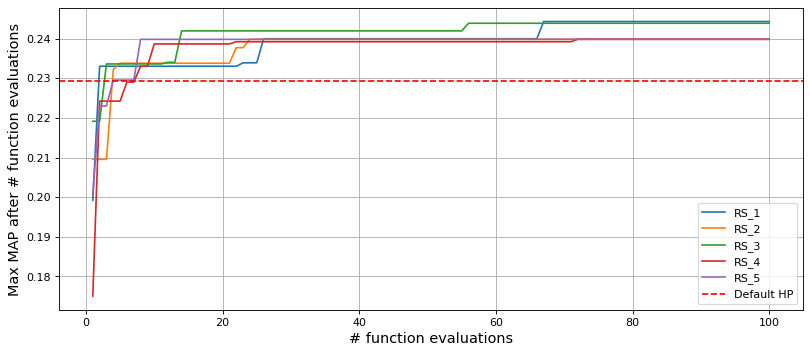

[{'run_id': 1, 'subject': 'robust_rs', 'metric': 'MAP', 'initial_metric': 0.1992, 'init_HP': ['leaves70', 'lr0.45', 'n200'], 'max_HP': ['leaves35', 'lr0.03', 'n1500'], 'max_metric': 0.2443, 'duration_100_eval_min': 519.08, 'n_evals_overcome_defa': 1}, {'run_id': 2, 'subject': 'robust_rs', 'metric': 'MAP', 'initial_metric': 0.2095, 'init_HP': ['leaves5', 'lr0.41', 'n950'], 'max_HP': ['leaves75', 'lr0.03', 'n1400'], 'max_metric': 0.2398, 'duration_100_eval_min': 479.75, 'n_evals_overcome_defa': 3}, {'run_id': 3, 'subject': 'robust_rs', 'metric': 'MAP', 'initial_metric': 0.2191, 'init_HP': ['leaves40', 'lr0.28', 'n1500'], 'max_HP': ['leaves35', 'lr0.03', 'n150'], 'max_metric': 0.2439, 'duration_100_eval_min': 686.04, 'n_evals_overcome_defa': 2}, {'run_id': 4, 'subject': 'robust_rs', 'metric': 'MAP', 'initial_metric': 0.1751, 'init_HP': ['leaves5', 'lr0.24', 'n100'], 'max_HP': ['leaves25', 'lr0.09', 'n1600'], 'max_metric': 0.2398, 'duration_100_eval_min': 658.44, 'n_evals_overcome_defa': 7

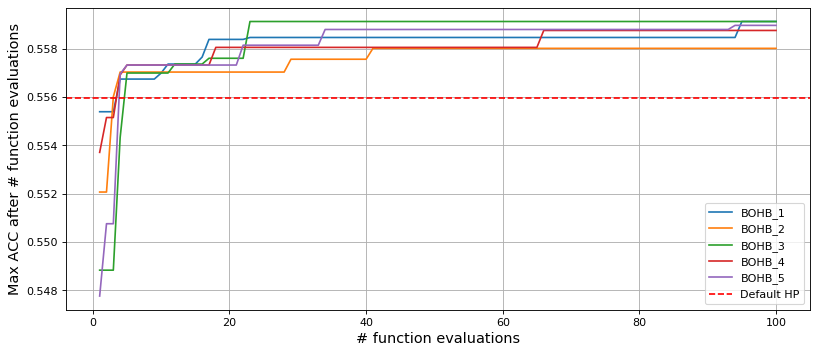

[{'run_id': 1, 'subject': 'tvqa_bohb', 'metric': 'ACC', 'initial_metric': 0.5554, 'init_HP': ['leaves10', 'lr0.2', 'n500'], 'max_HP': ['leaves5', 'lr0.44', 'n1350'], 'max_metric': 0.5591, 'duration_100_eval_min': 190.72, 'n_evals_overcome_defa': 3}, {'run_id': 2, 'subject': 'tvqa_bohb', 'metric': 'ACC', 'initial_metric': 0.5521, 'init_HP': ['leaves60', 'lr0.08', 'n1950'], 'max_HP': ['leaves45', 'lr0.11', 'n1200'], 'max_metric': 0.558, 'duration_100_eval_min': 308.21, 'n_evals_overcome_defa': 2}, {'run_id': 3, 'subject': 'tvqa_bohb', 'metric': 'ACC', 'initial_metric': 0.5488, 'init_HP': ['leaves90', 'lr0.03', 'n1100'], 'max_HP': ['leaves5', 'lr0.44', 'n600'], 'max_metric': 0.5591, 'duration_100_eval_min': 252.14, 'n_evals_overcome_defa': 4}, {'run_id': 4, 'subject': 'tvqa_bohb', 'metric': 'ACC', 'initial_metric': 0.5537, 'init_HP': ['leaves10', 'lr0.18', 'n600'], 'max_HP': ['leaves45', 'lr0.19', 'n1000'], 'max_metric': 0.5587, 'duration_100_eval_min': 210.42, 'n_evals_overcome_defa': 3}

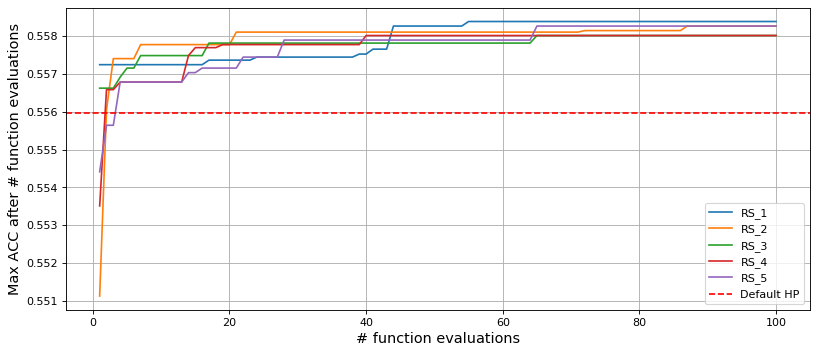

[{'run_id': 1, 'subject': 'tvqa_rs', 'metric': 'ACC', 'initial_metric': 0.5572, 'init_HP': ['leaves60', 'lr0.09', 'n1550'], 'max_HP': ['leaves10', 'lr0.23', 'n900'], 'max_metric': 0.5584, 'duration_100_eval_min': 410.8, 'n_evals_overcome_defa': 0}, {'run_id': 2, 'subject': 'tvqa_rs', 'metric': 'ACC', 'initial_metric': 0.5511, 'init_HP': ['leaves55', 'lr0.01', 'n1050'], 'max_HP': ['leaves45', 'lr0.14', 'n650'], 'max_metric': 0.5583, 'duration_100_eval_min': 373.21, 'n_evals_overcome_defa': 1}, {'run_id': 3, 'subject': 'tvqa_rs', 'metric': 'ACC', 'initial_metric': 0.5566, 'init_HP': ['leaves35', 'lr0.09', 'n1350'], 'max_HP': ['leaves50', 'lr0.06', 'n900'], 'max_metric': 0.558, 'duration_100_eval_min': 457.47, 'n_evals_overcome_defa': 0}, {'run_id': 4, 'subject': 'tvqa_rs', 'metric': 'ACC', 'initial_metric': 0.5535, 'init_HP': ['leaves100', 'lr0.39', 'n1450'], 'max_HP': ['leaves45', 'lr0.11', 'n1150'], 'max_metric': 0.558, 'duration_100_eval_min': 433.58, 'n_evals_overcome_defa': 1}, {'ru

In [8]:
# For each dataset and hpo method

only_test_flag = False
# only_test_flag = True

workdirs = [ 
            './deep-relevance-ranking/models/baselines/bioasq_dir/',
            './deep-relevance-ranking/models/baselines/robust_dir/',
            './TVQA/workdir/'
           ]
dev_defaults = [
                0.4371,
                0.2292,
                0.55597
               ]

test_defaults = [
                0.4703,
                0.2189,
                0.56291
               ]

hpo_methods = [
                'bohb', 
                'rs'
]

# adjust= 'min' # min|max|fixed
# adjust= 'max' # min|max|fixed
adjust= 'fixed' # min|max|fixed
n_limit = 0
n_results = 5 # max number of results to analyze

for wdir, dev_def, test_def in zip(workdirs, dev_defaults, test_defaults):
    for hpo_m in hpo_methods:
        print('\n\n###############################\n####### New Graph #############\n')
        # Get results_dir
        results_dirs = get_hpo_results_dir(wdir, hpo_m)

#         print(results_dirs)
        # Get mean, std
        results_files = [x + '/results.json' for x in results_dirs]

        if 'bioasq' in wdir.lower():
            dataset = 'bioasq'
        elif 'robust' in wdir.lower():
            dataset = 'robust'
        elif 'TVQA'.lower() in wdir.lower():
            dataset = 'tvqa'
        
#         print(dataset)
#         avg_res = get_avg_results(results_files)
        res_hpo = []
        for r in results_files[0:n_results]:
            r_hpo = load_results(r)
#             print('estas claves', list(r_hpo.keys()))
#             if only_test_flag:                
            if 'test_results' in r_hpo.keys():
                print('yes, there are results!')
#                 res_hpo.append(r_hpo)
            else:
                res_hpo.append(r_hpo)
        
        if not res_hpo:
            continue
        if adjust == 'min':
            n_limit = min(len(r['loss_data']) for r in res_hpo)
        elif adjust == 'fixed':
            n_limit = 100
            
        print(n_limit)
            
#         n_limit = 800
        
        [signals, stats] = plot_results(dataset, hpo_m, *res_hpo, dev_def=dev_def, test_def=test_def, n=0, n_lim=n_limit, time_flag=False, raw_flag=False, grid_f=True)
        
        print(stats)
#         pprint.pprint(stats)
    
        

        # Plot

        # Save results all results

In [9]:
# plot_results(rob_bohb_results, rob_rs_results,  default=0.2292, n=0, time_flag=True, raw_flag=True)
# plot_results(bio_bohb_results,bio_rs_results , default=0.4371, n=0, n_lim=0, time_flag=True)

In [10]:
# now = datetime.now()
# timestamp = datetime.timestamp(now)

# tvqa_bohb_dir = tvqa_bohb_file.replace('results.json','')
# tvqa_rs_dir = tvqa_rs_file.replace('results.json','')

# analyzed_results = {'tvqa_bohb': load_hpo_results(tvqa_bohb_dir),
#                     'tvqa_rs': load_hpo_results(tvqa_rs_dir)
#                     }

# analyzed_results_file = './tvqa_hpo_results_' + str(timestamp) + '.pkl'


In [11]:
# pickle.dump( analyzed_results, open(analyzed_results_file, 'wb'))

# loaded_results = pickle.load( open( analyzed_results_file, "rb" ))
# for k in loaded_results.keys():
#     print(loaded_results[k]['results_lines'][0], '\n')

In [12]:
# get_best_config(tvqa_bohb_dir, tvqa_rs_dir)